In [ ]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
from data import SimpleDataset, CellImageDataset
import seaborn as sns
import pandas as pd
from sklearn import mixture
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.special import softmax
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from microfilm.colorify import multichannel_to_rgb

In [149]:
imsize = 512
batch_size = 100
# DATA_DIR = Path("./dev-dataset-FUCCI/")
DATA_DIR = Path("/data/ishang/FUCCI-dataset/")
NAME = "native_res_512_min_max"

In [2]:

# RGB_DATASET = DATA_DIR / "rgb_native_res_512_min_max.pt"
# dataset = SimpleDataset(path=RGB_DATASET)
# dataset = CellImageDataset(DATA_DIR / "index_rgb_native_res_512_min_max.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])

dataset = CellImageDataset(DATA_DIR / "index_{name}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Loading dataset images: 100%|██████████| 5/5 [02:32<00:00, 30.44s/it]


Loaded 46203 images from 2346 files.


In [3]:
FUCCI_mean_intensities = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    FUCCI_mean_intensities.append(torch.mean(batch[:, 2:], dim=(2, 3)))
FUCCI_mean_intensities = torch.cat(FUCCI_mean_intensities, dim=0)

Computing mean intensities: 100%|██████████| 463/463 [02:30<00:00,  3.08it/s]


In [4]:
print(torch.isnan(FUCCI_mean_intensities).sum())
print(torch.log10(torch.min(FUCCI_mean_intensities[torch.nonzero(FUCCI_mean_intensities[:, 0]), 0])))
print(torch.log10(torch.min(FUCCI_mean_intensities[torch.nonzero(FUCCI_mean_intensities[:, 1]), 1])))
print(len(FUCCI_mean_intensities))

tensor(0)
tensor(-5.3826)
tensor(-4.9734)
46203


In [5]:
log_min = torch.tensor([10 ** (-5.4), 10 ** (-5)])
FUCCI_log_mean_intensities = torch.log10(FUCCI_mean_intensities + (~(FUCCI_mean_intensities > 0)) * log_min)
print(torch.min(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 0]), 0]))
print(torch.min(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 1]), 1]))
print(torch.max(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 0]), 0]))
print(torch.max(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 1]), 1]))
print(torch.isnan(FUCCI_log_mean_intensities).sum())
print(len(FUCCI_log_mean_intensities))

tensor(-5.3826)
tensor(-5.)
tensor(-0.3235)
tensor(-0.3591)
tensor(0)
46203


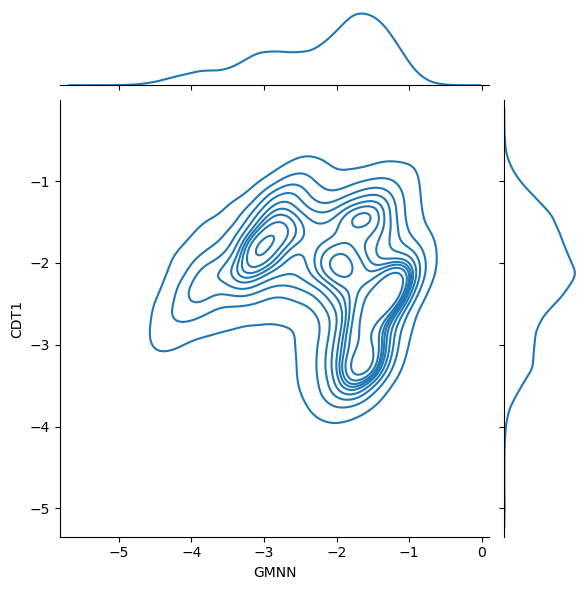

In [6]:
pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities.numpy(), columns=['GMNN', 'CDT1'])
sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind='kde')

Here GMNN has 10^4-fold meaningful range, whereas CDT1 has about 10^3-fold.

In [7]:
# FUCCI_log_mean_intensities_rescaled = FUCCI_log_mean_intensities * torch.tensor([1.0, 4/3])
# pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities_rescaled.numpy(), columns=['GMNN', 'CDT1'])
# sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind='kde')

<Axes: xlabel='GMNN', ylabel='CDT1'>

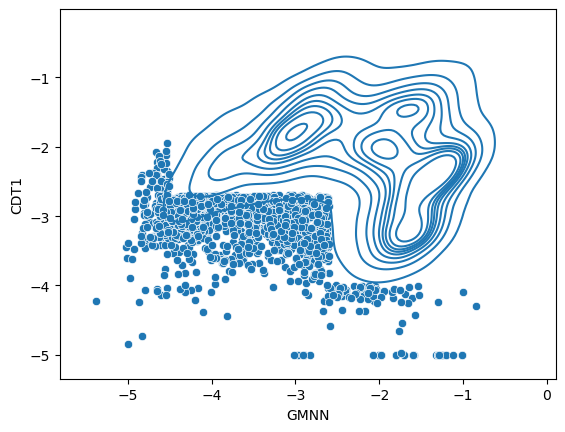

In [8]:
sns.kdeplot(data=pseudo_time_df, x='GMNN', y='CDT1')
outliers_index = ((pseudo_time_df['GMNN'] < -2.6) & (pseudo_time_df['CDT1'] < -2.7) | (pseudo_time_df['GMNN'] < -4.5) | (pseudo_time_df['CDT1'] < -4))
outlier = pseudo_time_df[outliers_index]
sns.scatterplot(data=outlier, x='GMNN', y='CDT1')

In [9]:
print(np.sum(outliers_index) / len(outliers_index))
print(torch.min(FUCCI_log_mean_intensities[:, 0]), torch.max(FUCCI_log_mean_intensities[:, 0]))
print(torch.min(FUCCI_log_mean_intensities[:, 1]), torch.max(FUCCI_log_mean_intensities[:, 1]))

0.034326775317620066
tensor(-5.3826) tensor(-0.3235)
tensor(-5.) tensor(-0.3591)


So 3.36% of the data is outside the range we really see in the KDE plots

400
130
torch.Size([4, 512, 512])


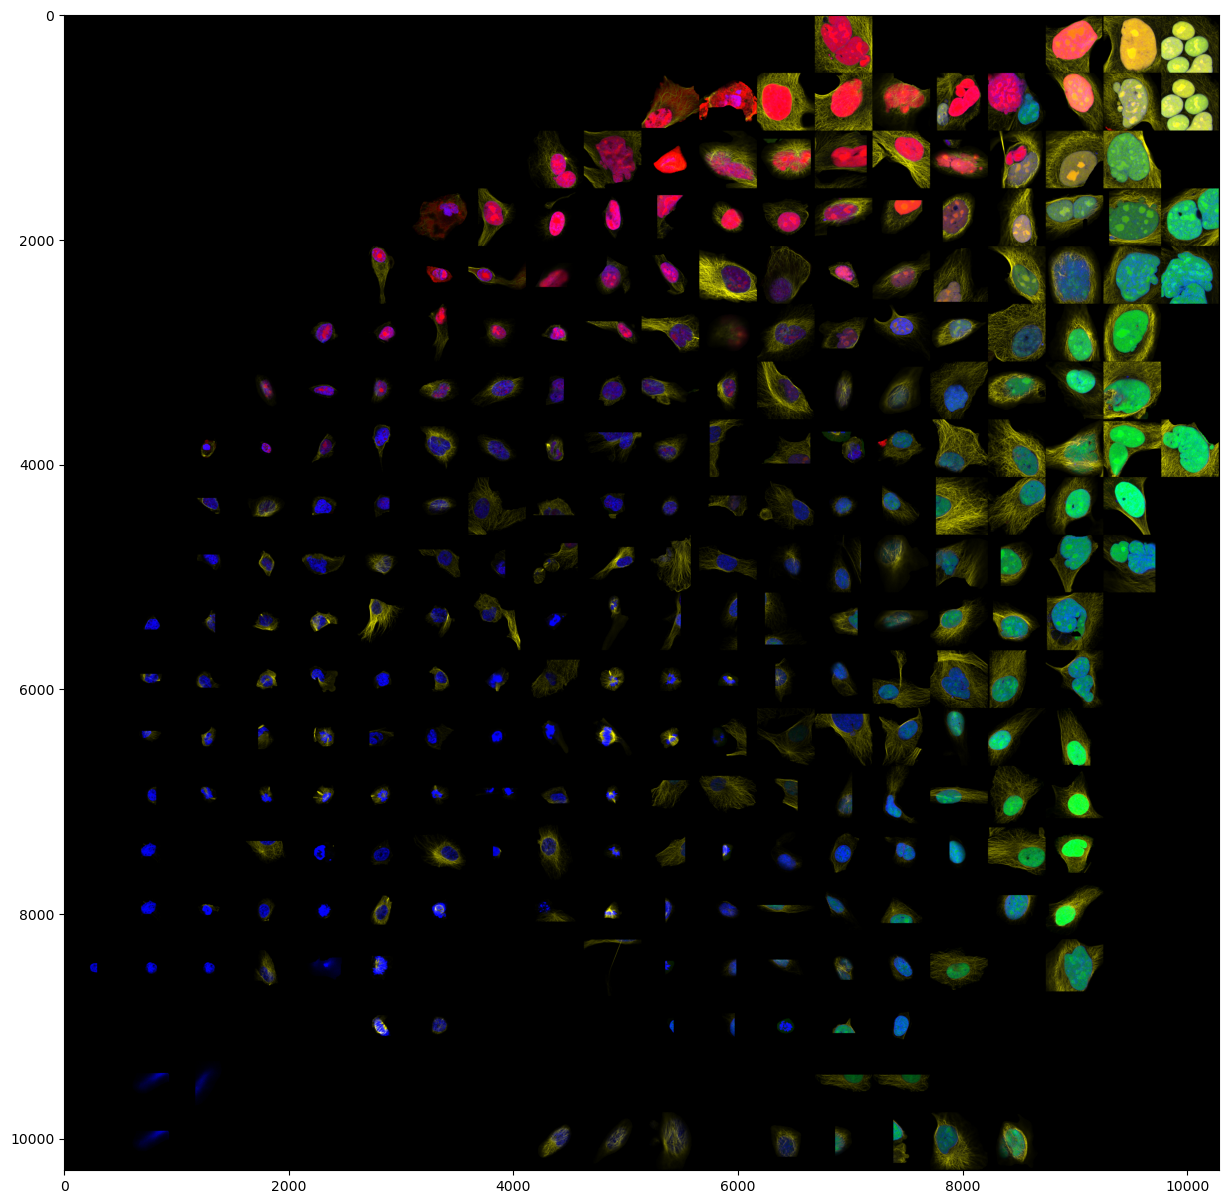

In [10]:
# cdts = range(-1, -8, -0.5) # so the grid with go top to bottom,
cdts = np.linspace(-0.3, -5, 20)
# gmmns = range(-5, 0, 0.5) # left to right
gmnns = np.linspace(-5.3, -0.3, 20)
nrow = len(gmnns)
images = []
blanks = 0
for cdt in cdts:
    for gmnn in gmnns:
        # find the image closest to this point in the intensity space
        point = torch.tensor([gmnn, cdt])
        distances = torch.sum((FUCCI_log_mean_intensities - point) ** 2, dim=1)
        closest = torch.argmin(distances)
        # if the closest is within 0.1, then we can use it, else just add a blank image
        if distances[closest] > ((0.5 * (gmnns[1] - gmnns[0])) ** 2 + (0.5 * (cdts[1] - cdts[0])) ** 2):
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print(len(images))
print(blanks)
print(images[0].shape)


grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)
plt.figure(figsize=(15, 15))
plt.imshow(grid)

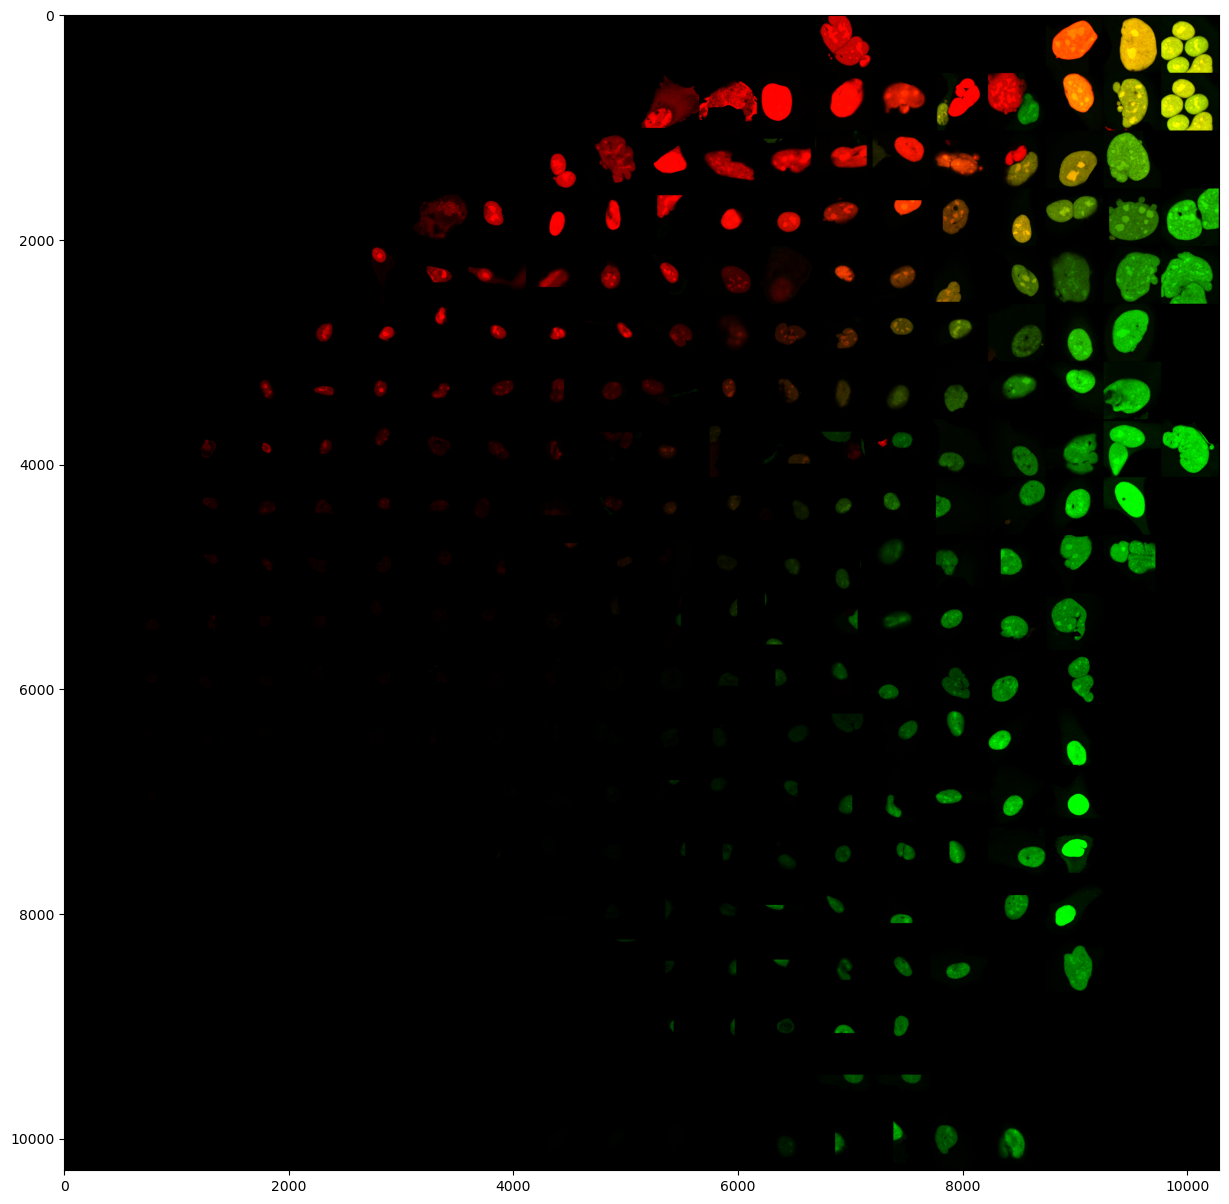

In [11]:
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid[2:].cpu().numpy(), cmaps=cmaps[2:])
plt.figure(figsize=(15, 15))
plt.imshow(grid)

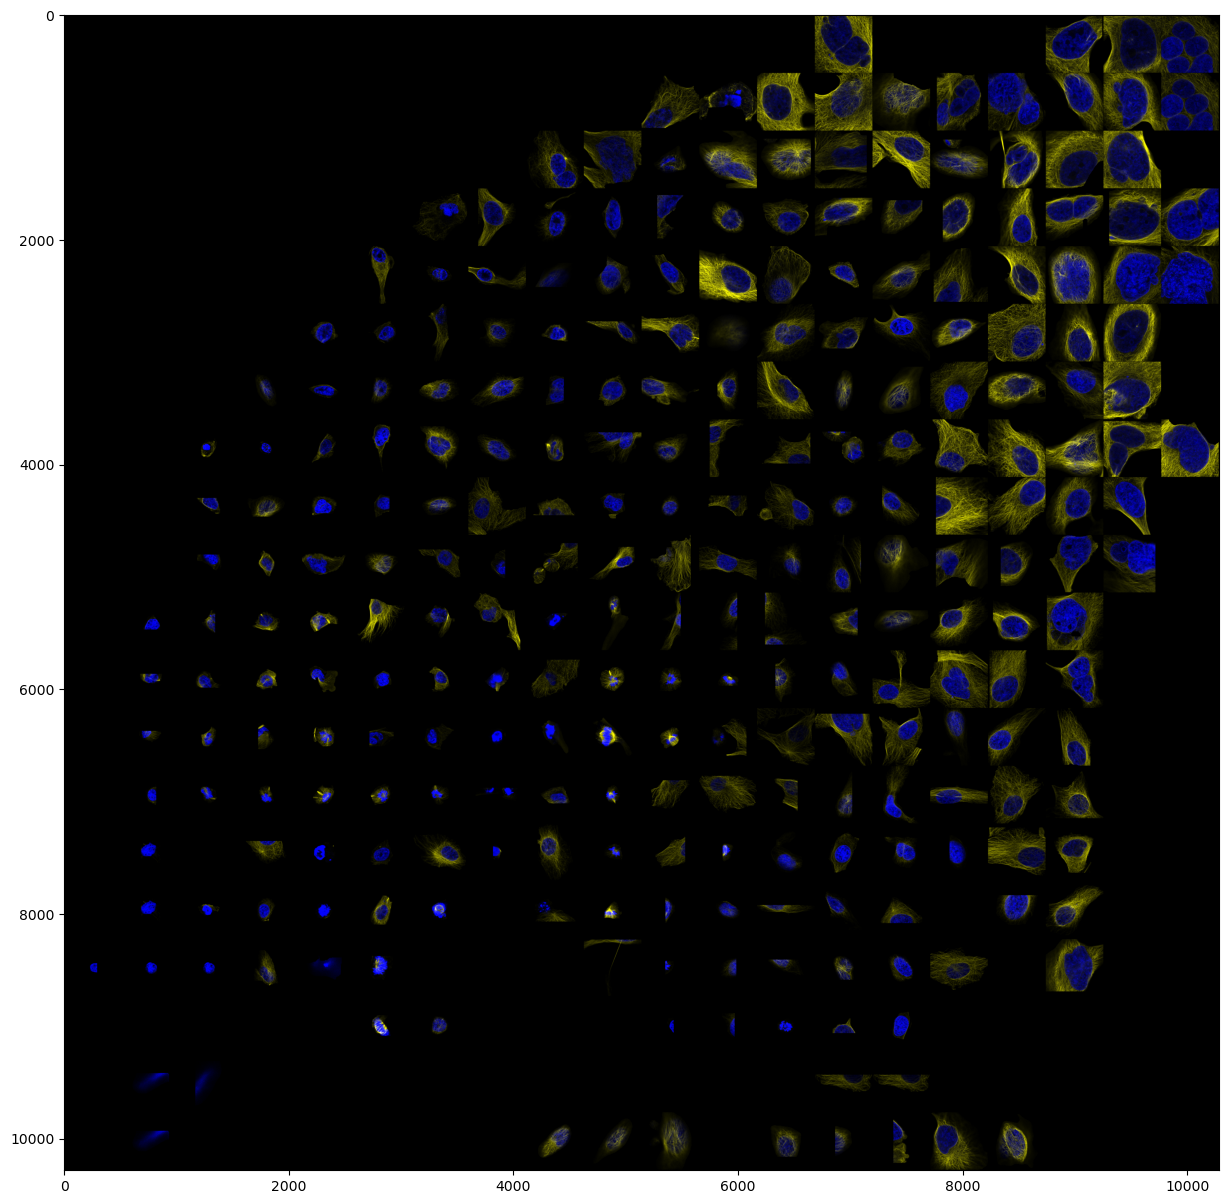

In [12]:
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.imshow(grid)

![pseudotime](./pseudotime.png)

Based on this the phases of the cell in these data are:

Top Left Mode: G1

Middle Mode: G1/S

Top Right Top: S

Top Right Bottom: G2

Dead Bottom (minimum CDT): M

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


<Axes: >

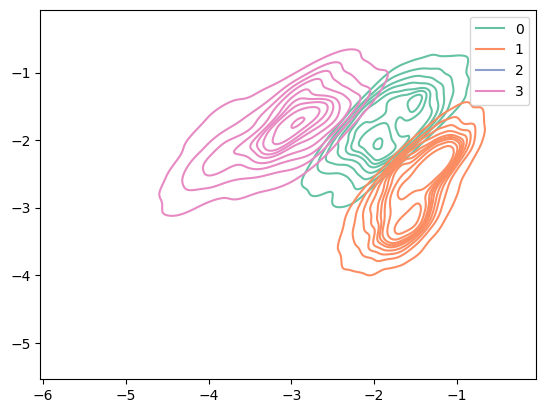

In [13]:
n_components, prior = 4, 1e-5
indices = torch.randperm(len(FUCCI_log_mean_intensities))
X_train = FUCCI_log_mean_intensities[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities[indices[len(indices) // 2:]]
clf_cc = mixture.BayesianGaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++",
                                                  weight_concentration_prior=prior)
# from sklearn.decomposition import NMF
# nmf = NMF(n_components=2)
# X_train_nmf = nmf.fit_transform(X_train * -1)
# clf_cc_3_weight.fit(X_train_nmf)
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [14]:
# sns.jointplot(x=X_train_nmf[:, 0], y=X_train_nmf[:, 1], hue=y, palette="Set2")

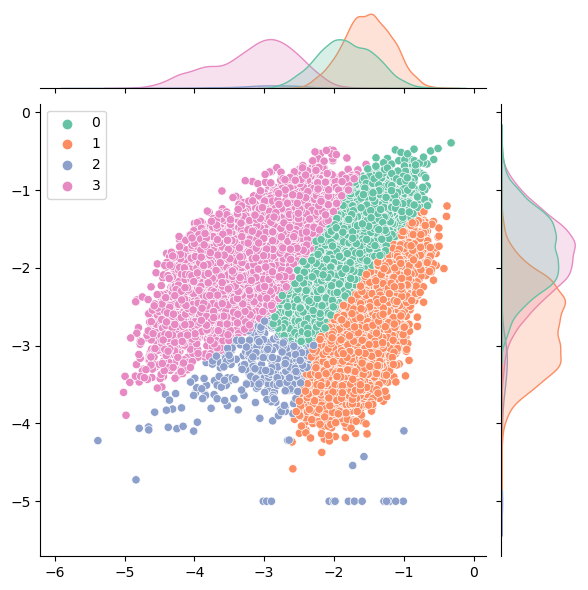

In [15]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [16]:
w = clf_cc.weights_
print(w[1], w[2], w[0], w[3])

0.34524601662839843 0.04212196359391342 0.2636518725753122 0.34898014720237586


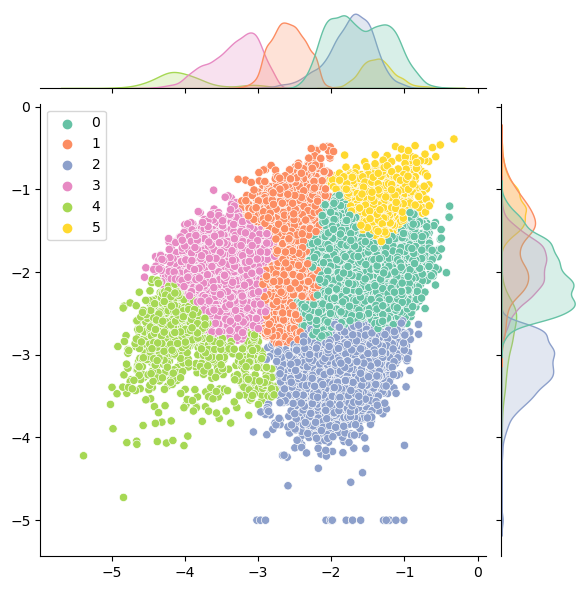

In [17]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=6).fit(X_train)
sns.jointplot(x=X_train[:,0], y=X_train[:,1], hue=clustering.labels_, palette="Set2")

In [18]:
order = [4, 2, 0, 5, 1, 3]
for i in order:
    print(np.sum(clustering.labels_ == i) / len(clustering.labels_))

0.05255183758278863
0.21401670923336652
0.32864378165447383
0.06618761092593395
0.16601012943162632
0.17258993117181073


<Axes: >

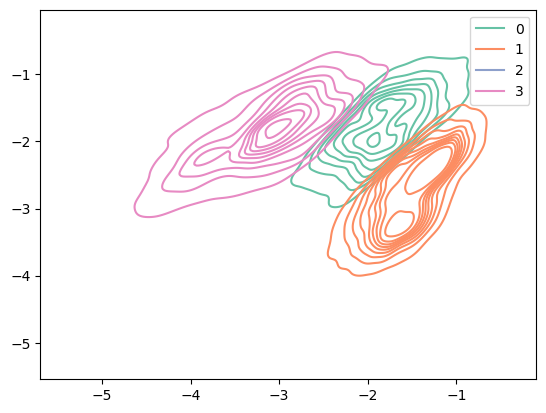

In [19]:
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

![pseudoints](./pseudo_ints.png)
![system](./system.png)

From the images below, we might expect the following proportions:

M: 3; M/G1:6 + G1: 29; G1/S: 7; S:16, G2: 15

So M: 3; G1:35; S:23; G2:15 or 4%, 45%, 30%, 20% (which makes sense given the breakdown above)

That means the GMM above primarily over-estimates S and underestimates G1, which is strangely paralleled by the DINO model

![progpics](./prog_pics.png)

<Axes: >

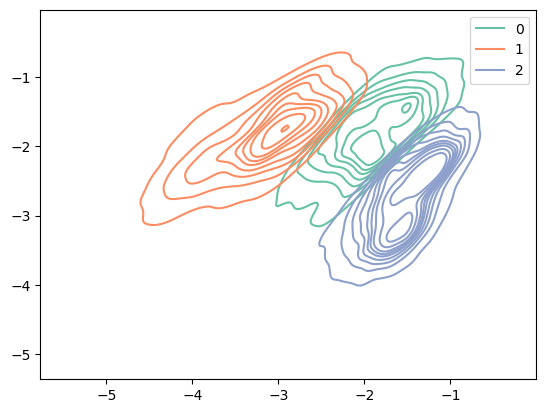

In [20]:
clf_cc = mixture.GaussianMixture(n_components=3, weights_init=(0.5, 0.3, 0.2), n_init=10, covariance_type="full", init_params="k-means++")
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

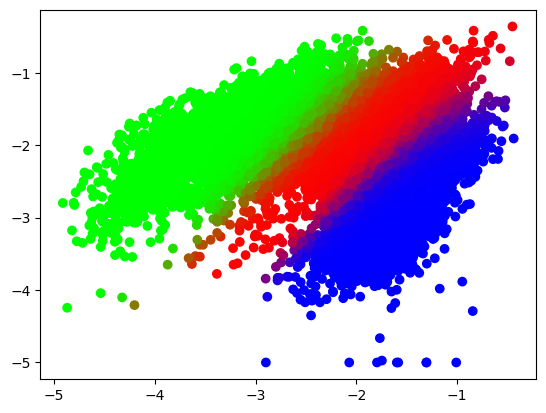

In [21]:
y = clf_cc.predict_proba(X_pred)
y = y / np.sum(y, axis=-1, keepdims=True)
# y = softmax(y / 3, axis=-1)
plt.scatter(X_pred[:10000, 0], X_pred[:10000, 1], c=y[:10000])

<Axes: >

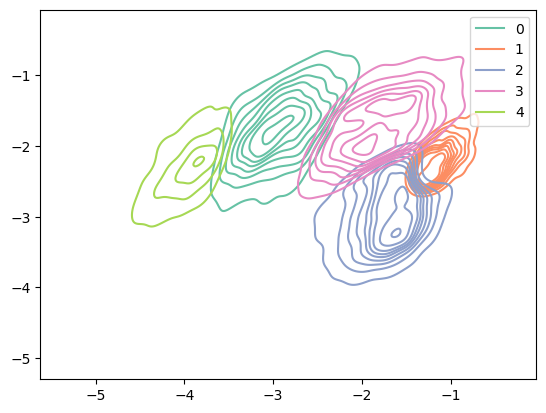

In [22]:
indices = torch.randperm(len(FUCCI_log_mean_intensities))
X_train = FUCCI_log_mean_intensities[indices[:len(indices) // 2]]
clf_cc_5 = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
clf_cc_5.fit(X_train)
X_pred = FUCCI_log_mean_intensities[indices[len(indices) // 2:]]
y = clf_cc_5.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [23]:
FUCCI_intensities_nonzero = []
FUCCI_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    FUCCI_intensity_sums.append(torch.sum(batch[:, 2:], dim=(2, 3)))
    FUCCI_intensities_nonzero.append(torch.sum(batch[:, 2:] > 0, dim=(2, 3)))
FUCCI_intensity_sums = torch.cat(FUCCI_intensity_sums, dim=0)
FUCCI_intensities_nonzero = torch.cat(FUCCI_intensities_nonzero, dim=0)

Computing mean intensities: 100%|██████████| 463/463 [03:16<00:00,  2.36it/s]


In [24]:
def two_sig_fig_floor(x):
    return torch.floor(x / torch.pow(10.0, torch.floor(torch.log10(x)) - 1)) * torch.pow(10.0, torch.floor(torch.log10(x)) - 1)

print("Number of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(FUCCI_intensities_nonzero[:, 0]), torch.max(FUCCI_intensities_nonzero[:, 0]))
print(torch.min(FUCCI_intensities_nonzero[:, 1]), torch.max(FUCCI_intensities_nonzero[:, 1]))

print("\nNumber of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = FUCCI_intensities_nonzero[:, 0].nonzero().flatten()
nonzero_1 = FUCCI_intensities_nonzero[:, 1].nonzero().flatten()

print(torch.min(FUCCI_intensities_nonzero[nonzero_0, 0]), torch.min(FUCCI_intensities_nonzero[:, 0]))
print(torch.min(FUCCI_intensities_nonzero[nonzero_1, 1]), torch.min(FUCCI_intensities_nonzero[:, 1]))
nonzero_eps = torch.tensor([torch.min(FUCCI_intensities_nonzero[nonzero_0, 0]), torch.min(FUCCI_intensities_nonzero[nonzero_1, 1])])
nonzero_eps = two_sig_fig_floor(nonzero_eps)
print("eps: ", nonzero_eps)

print("\nIntensity of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(FUCCI_intensity_sums[:, 0]), torch.max(FUCCI_intensity_sums[:, 0]))
print(torch.min(FUCCI_intensity_sums[:, 1]), torch.max(FUCCI_intensity_sums[:, 1]))

print("\nIntensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = FUCCI_intensity_sums[:, 0].nonzero().flatten()
nonzero_1 = FUCCI_intensity_sums[:, 1].nonzero().flatten()

print(torch.min(FUCCI_intensity_sums[nonzero_0, 0]), torch.min(FUCCI_intensity_sums[:, 0]))
print(torch.min(FUCCI_intensity_sums[nonzero_1, 1]), torch.min(FUCCI_intensity_sums[:, 1]))
sum_eps = torch.tensor([torch.min(FUCCI_intensity_sums[nonzero_0, 0]), torch.min(FUCCI_intensity_sums[nonzero_1, 1])])
sum_eps = two_sig_fig_floor(sum_eps)
print("eps: ", sum_eps)

Number of nonzero cells, min/max for GMNN and CDT1
tensor(354) tensor(260610)
tensor(0) tensor(229881)

Number of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1
tensor(354) tensor(354)
tensor(438) tensor(0)
eps:  tensor([350., 430.])

Intensity of nonzero cells, min/max for GMNN and CDT1
tensor(1.0863) tensor(124457.5938)
tensor(0.) tensor(114660.0391)

Intensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1
tensor(1.0863) tensor(1.0863)
tensor(2.7871) tensor(0.)
eps:  tensor([1.0000, 2.7000])


In [25]:
FUCCI_log_mean_intensities_nonzero = torch.log10((FUCCI_intensity_sums + sum_eps) / (FUCCI_intensities_nonzero + nonzero_eps))
for i in range(FUCCI_log_mean_intensities_nonzero.shape[1]):
    print(len(FUCCI_log_mean_intensities_nonzero[torch.isnan(FUCCI_log_mean_intensities_nonzero[:, i])]),
        FUCCI_log_mean_intensities_nonzero[torch.isnan(FUCCI_log_mean_intensities_nonzero[:, i])][:10, i])
    print(len(FUCCI_log_mean_intensities_nonzero[torch.isinf(FUCCI_log_mean_intensities_nonzero[:, i])]),
        FUCCI_log_mean_intensities_nonzero[torch.isinf(FUCCI_log_mean_intensities_nonzero[:, i])][:10, i])
print(torch.min(FUCCI_log_mean_intensities_nonzero[:, 0]), torch.max(FUCCI_log_mean_intensities_nonzero[:, 0]))
print(torch.min(FUCCI_log_mean_intensities_nonzero[:, 1]), torch.max(FUCCI_log_mean_intensities_nonzero[:, 1]))

0 tensor([])
0 tensor([])
0 tensor([])
0 tensor([])
tensor(-2.6910) tensor(-0.1725)
tensor(-2.2393) tensor(-0.0418)


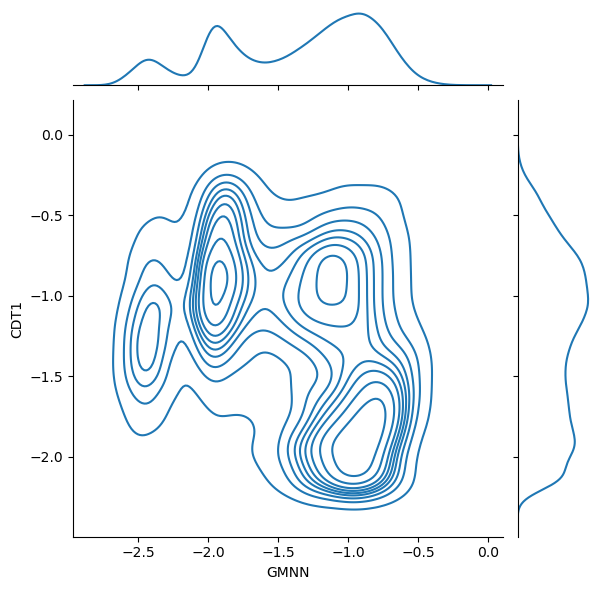

In [26]:
pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities_nonzero.numpy(), columns=['GMNN', 'CDT1'])
sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind="kde")

In [61]:
cdts = np.linspace(0.0, -2.2, 20) # so the grid with go top to bottom,
gmnns = np.linspace(-2.7, -0.2, 20) # left to right
nrow = len(gmnns)
images = []
blanks = 0
for cdt in cdts:
    for gmnn in gmnns:
        # find the image closest to this point in the intensity space
        point = torch.tensor([gmnn, cdt])
        distances = torch.sum((FUCCI_log_mean_intensities_nonzero - point) ** 2, dim=1)
        closest = torch.argmin(distances)
        # if the closest is within 0.1, then we can use it, else just add a blank image
        if distances[closest] > ((0.5 * (gmnns[1] - gmnns[0])) ** 2 + (0.5 * (cdts[1] - cdts[0])) ** 2):
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print(len(images))
print(blanks)
print(images[0].shape)

grid = make_grid(images, nrow=nrow)
print(grid.shape)

400
45
torch.Size([4, 512, 512])
torch.Size([4, 10282, 10282])


In [62]:
xlabels = np.round(gmnns[::2], 1)
xticks = (gmnns[::2] - np.min(gmnns)) / (np.max(gmnns) - np.min(gmnns)) * grid.shape[0]
print(xticks)
print(xlabels)
ylabels = np.round(cdts[::2], 1)
yticks = (cdts[::-2] - np.min(cdts)) / (np.max(cdts) - np.min(cdts)) * grid.shape[1]
print(yticks)
print(ylabels)

[0.         0.42105263 0.84210526 1.26315789 1.68421053 2.10526316
 2.52631579 2.94736842 3.36842105 3.78947368]
[-2.7 -2.4 -2.2 -1.9 -1.6 -1.4 -1.1 -0.9 -0.6 -0.3]
[   0.         1082.31578947 2164.63157895 3246.94736842 4329.26315789
 5411.57894737 6493.89473684 7576.21052632 8658.52631579 9740.84210526]
[ 0.  -0.2 -0.5 -0.7 -0.9 -1.2 -1.4 -1.6 -1.9 -2.1]


(10282, 10282, 4)


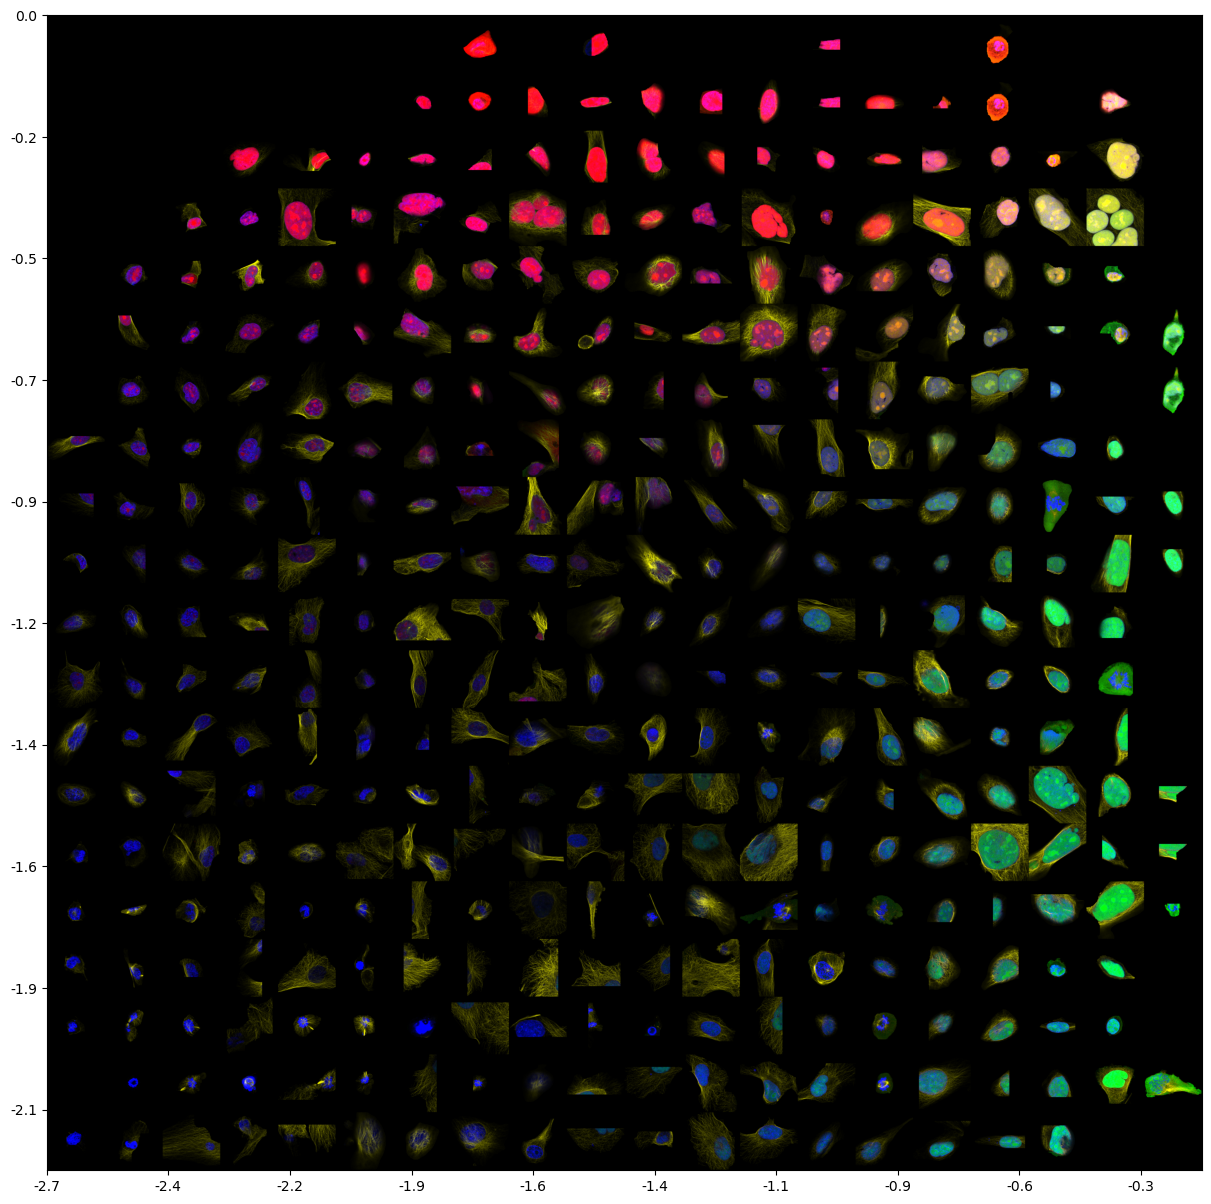

In [58]:

cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)

plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

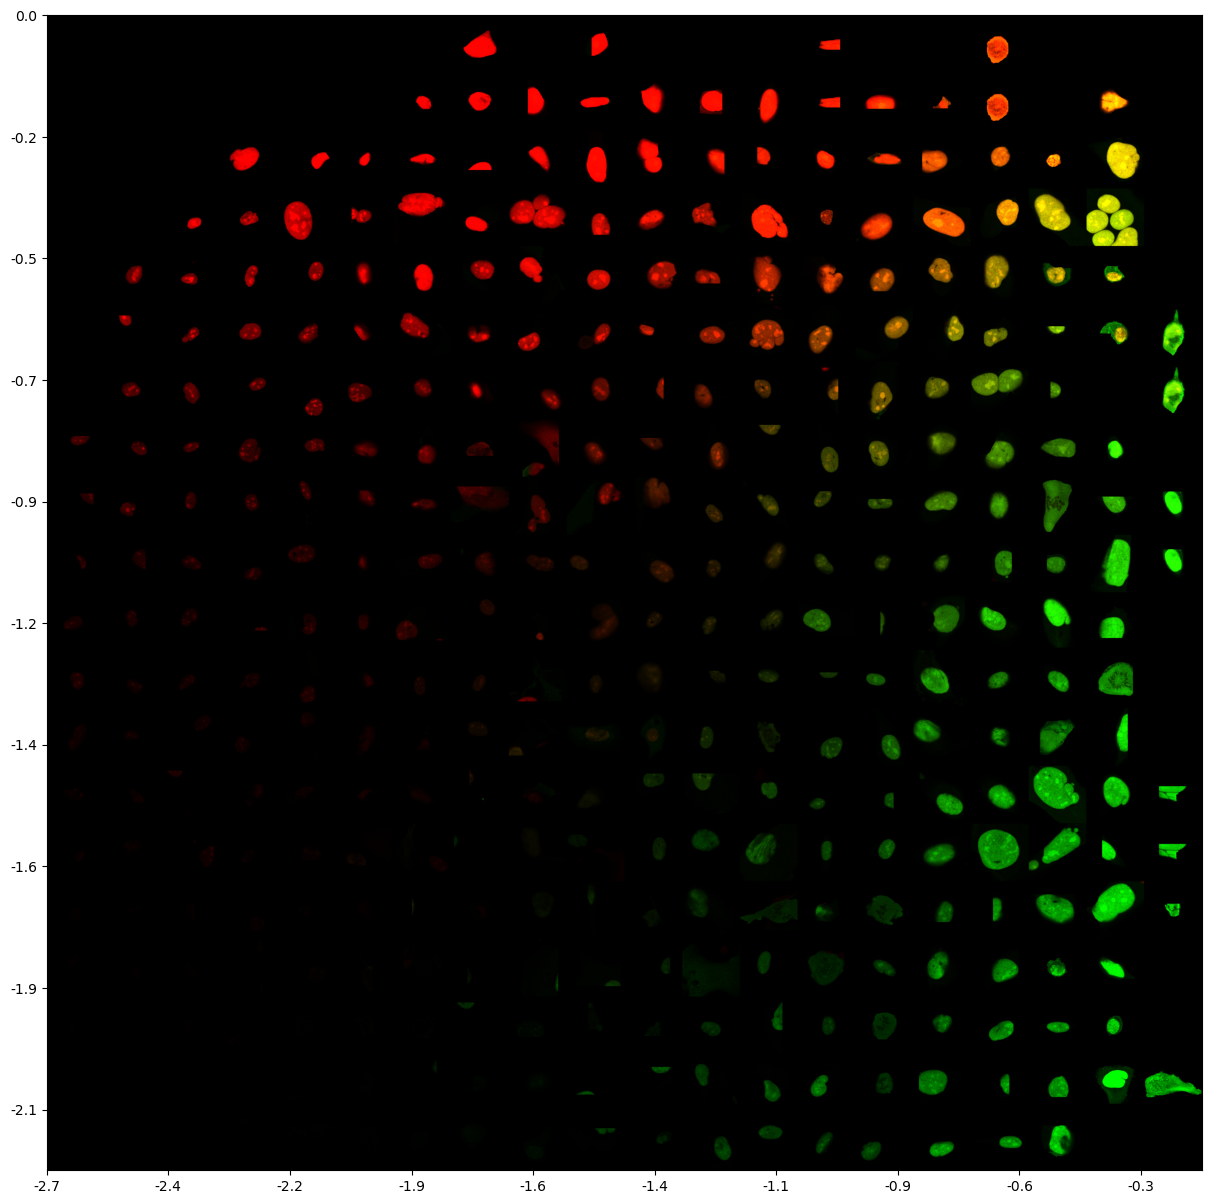

In [59]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[2:].cpu().numpy(), cmaps=cmaps[2:])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

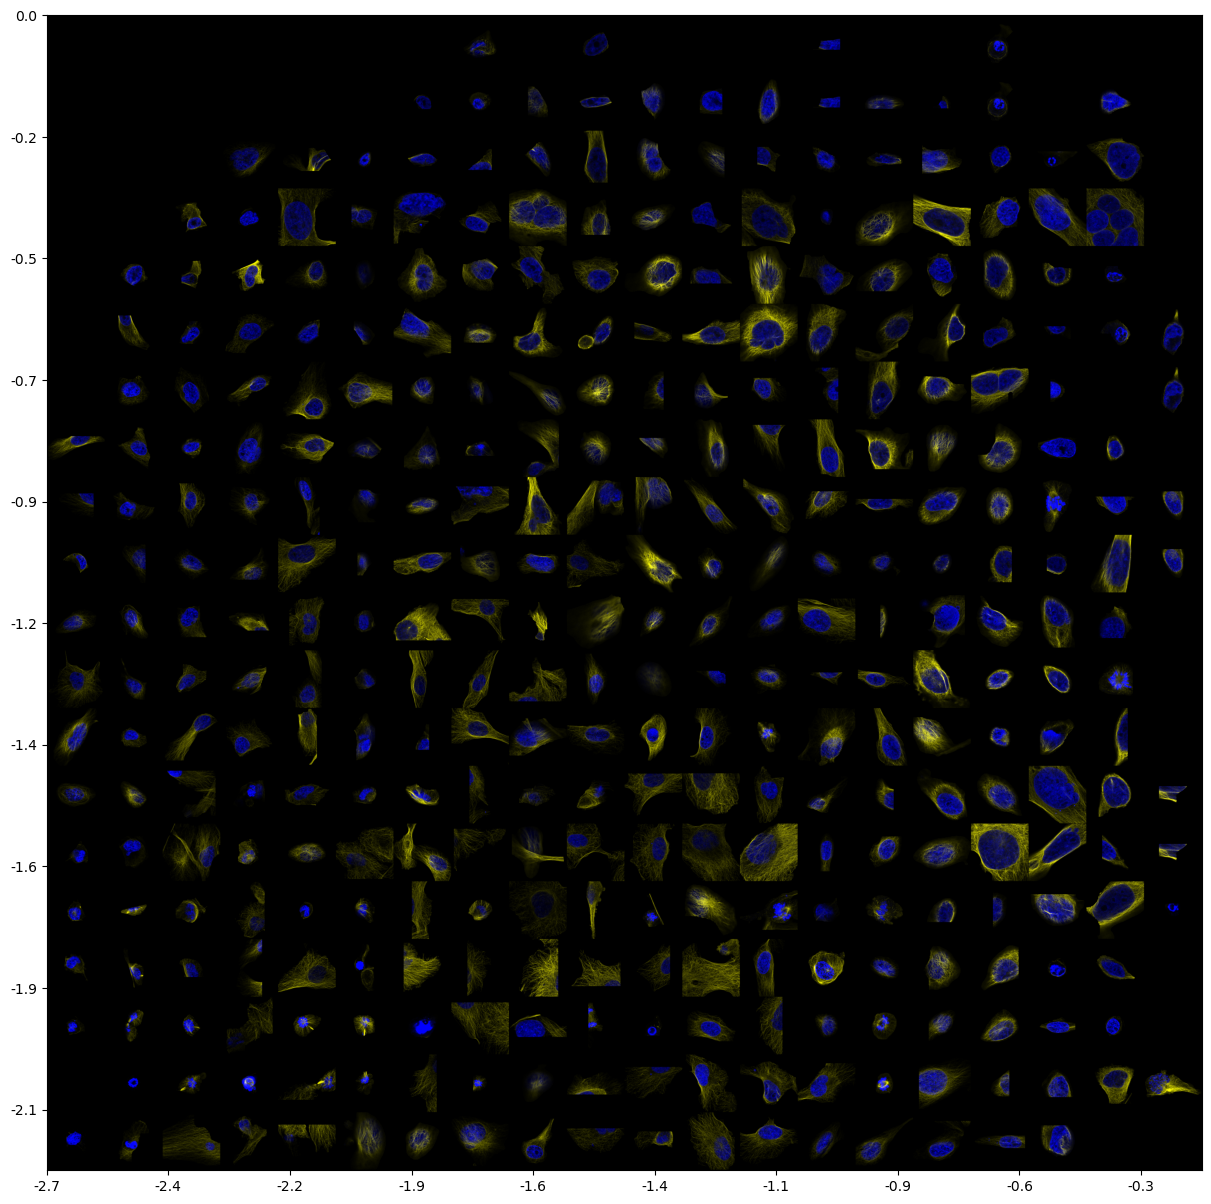

In [60]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

<Axes: >

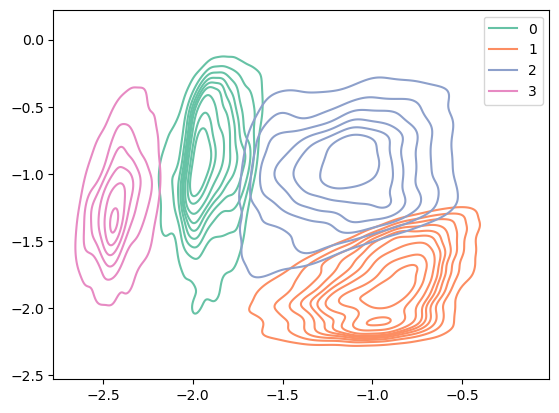

In [31]:
n_components = 4
indices = torch.randperm(len(FUCCI_log_mean_intensities_nonzero))
X_train = FUCCI_log_mean_intensities_nonzero[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities_nonzero[indices[len(indices) // 2:]]
clf_cc = mixture.GaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++")
clf_cc.fit(X_train)
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

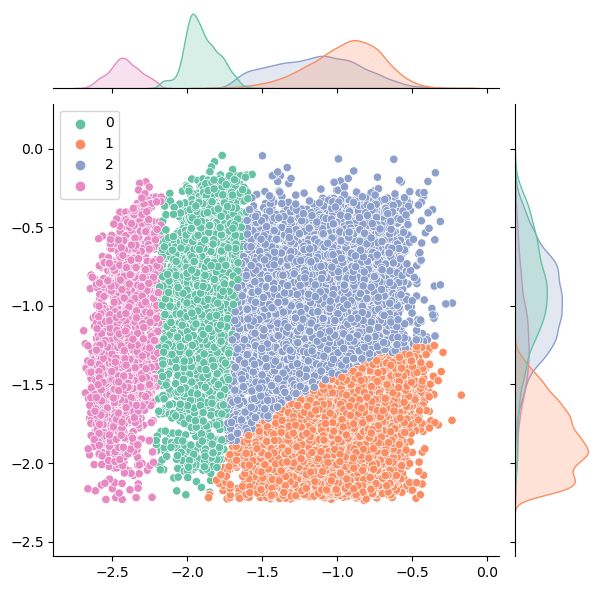

In [32]:
sns.jointplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


<Axes: >

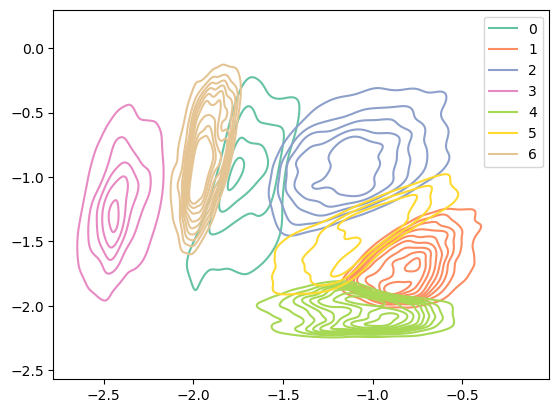

In [33]:
n_components, prior = 7, 1e-3
indices = torch.randperm(len(FUCCI_log_mean_intensities_nonzero))
X_train = FUCCI_log_mean_intensities_nonzero[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities_nonzero[indices[len(indices) // 2:]]
clf_cc = mixture.BayesianGaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++",
                                                  weight_concentration_prior=prior)
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

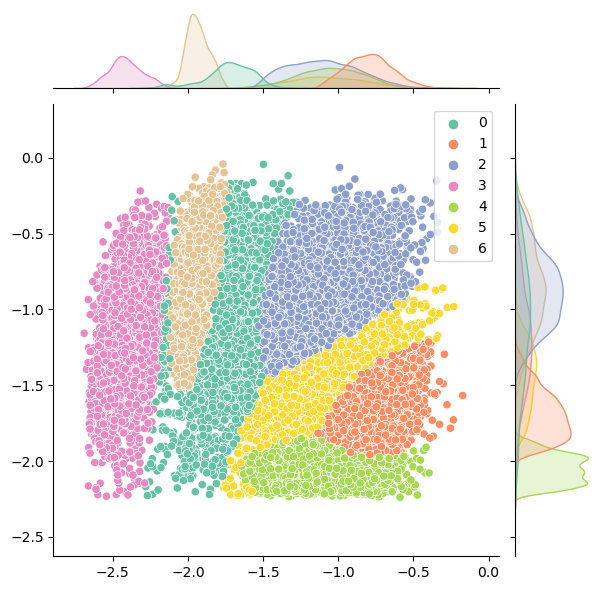

In [34]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [36]:
import pickle
GMM_FILE = DATA_DIR / "gmm.pkl"
pickle.dump(clf_cc, open(GMM_FILE, "wb"))

In [ ]:
# histogram of pseudotime using PCA with 1 component
pca = PCA(n_components=1)
y_PCA = pca.fit_transform(y)
y_PCA = np.squeeze(y_PCA)
plt.hist(y_PCA, bins=100)

In [35]:
com = torch.mean(FUCCI_log_mean_intensities_nonzero, dim=0)
print(com)

tensor([-1.3828, -1.2867])


In [112]:
clf_cc_pts = mixture.BayesianGaussianMixture(n_components=6, n_init=10, weight_concentration_prior=1e-4).fit(X_train)

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [158]:
clustering = AgglomerativeClustering(n_clusters=7)
clustering.fit(FUCCI_log_mean_intensities_nonzero)
y_pred = clustering.labels_


torch.Size([46203])


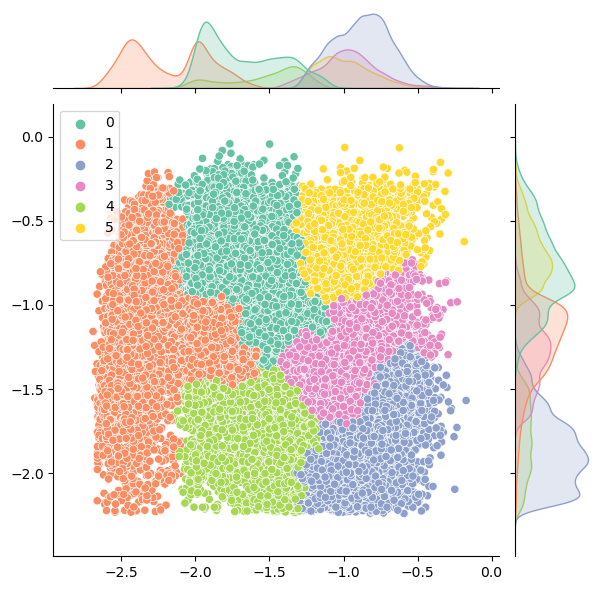

In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:,0], y=FUCCI_log_mean_intensities_nonzero[:,1], hue=y_pred, palette='Set2')

# convert y_pred to torch tensor and write to DATA_DIR / "ward_probs_{name}.pt"
y_pred = torch.tensor(y_pred)
print(y_pred.shape)


In [154]:
remap = [1, 0, 5, 3, 2, 4]
print(y_pred[:10])
for i in range(len(y_pred)):
    y_pred[i] = remap.index(y_pred[i])
print(y_pred[:10])

tensor([0, 0, 0, 1, 2, 0, 3, 5, 5, 5])
tensor([1, 1, 1, 0, 4, 1, 3, 2, 2, 2])


In [157]:
file_name = DATA_DIR / f"ward_probs_{NAME}.pt"
torch.save(y_pred, file_name)
print(f"Saved to {file_name}")

Saved to /data/ishang/FUCCI-dataset/ward_probs_native_res_512_min_max.pt


torch.Size([10416, 2])
torch.Size([9022, 2])
torch.Size([12600, 2])
torch.Size([5935, 2])
torch.Size([3416, 2])
torch.Size([4814, 2])
The ellipse is given by -0.29x^2 + 0.034xy+-0.135y^2+-0.92x+-0.423y = 1


/tmp/ipykernel_3755333/2358010723.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()


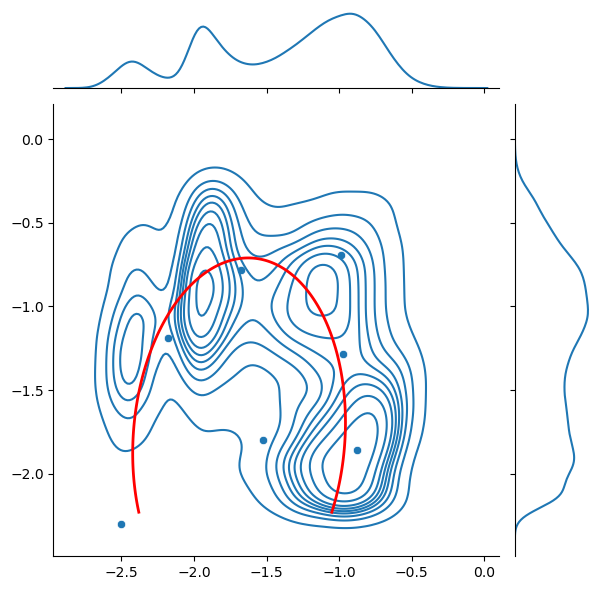

In [153]:
# https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points

# fit an ellipse to the means and plot
# print(clf_cc_pts.weights_)
# means = clf_cc_pts.means_
# means = np.concatenate((means, np.array([[-2.3, -2.3]])))


means = []
for i in range(n_components):
    print(FUCCI_log_mean_intensities_nonzero[clustering.labels_ == i, :].shape)
    means.append(torch.mean(FUCCI_log_mean_intensities_nonzero[clustering.labels_ == i, :], dim=0).cpu().numpy())
means = np.array(means)
means = np.concatenate((means, np.array([[-2.5, -2.3]])))

# Extract x coords and y coords of the ellipse as column vectors
X = means[:,0:1]
Y = means[:,1:]
# X = X_train[:, 0:1]
# Y = X_train[:, 1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

x_coord = np.linspace(torch.min(FUCCI_log_mean_intensities_nonzero[:,0]),torch.max(FUCCI_log_mean_intensities_nonzero[:,0]),300)
y_coord = np.linspace(torch.min(FUCCI_log_mean_intensities_nonzero[:,1]),torch.max(FUCCI_log_mean_intensities_nonzero[:,1]),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1], kind='kde', palette="Set2")
sns.scatterplot(x=means[:, 0], y=means[:, 1])
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

In [99]:
gmnn_gmm = mixture.BayesianGaussianMixture(n_components=3, n_init=10, weight_concentration_prior=1e-4).fit(X_train[:, 0:1])
cdt_gmm = mixture.BayesianGaussianMixture(n_components=3, n_init=10, weight_concentration_prior=1e-4).fit(X_train[:, 1:2])

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [107]:
gmnn_modes = np.stack([gmnn_gmm.means_.flatten(), gmnn_gmm.weights_.flatten()], axis=-1)
gmnn_modes = gmnn_modes[gmnn_modes[:, 0].argsort()]
cdt_modes = np.stack([cdt_gmm.means_.flatten(), cdt_gmm.weights_.flatten()], axis=-1)
cdt_modes = cdt_modes[cdt_modes[:, 0].argsort()]

[0.0097118  0.02433726 0.16027136 0.16027136 0.42118044 0.16027136
 0.0639564 ]
The ellipse is given by -0.325x^2 + 0.105xy+-0.203y^2+-0.934x+-0.477y = 1


/tmp/ipykernel_3755333/902747385.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()


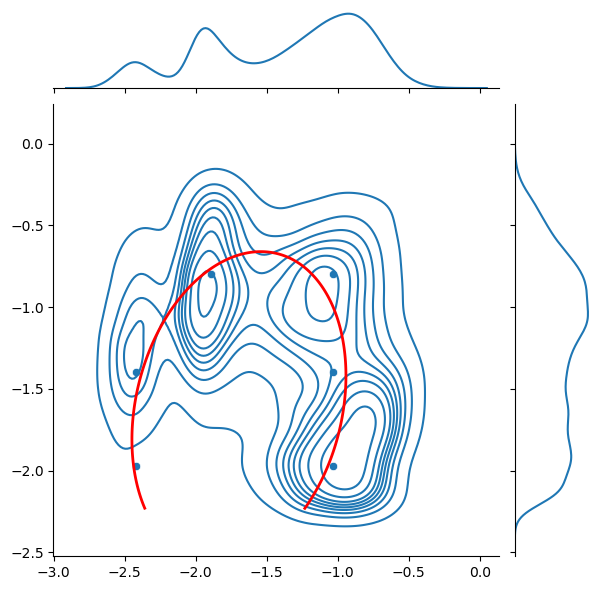

In [111]:
points = np.array([
    [0, 0],
    [0, 1],
    [1, 2],
    [1, 2],
    [2, 2],
    [2, 1],
    [2, 0],
])

key_points = np.asarray([[gmnn_modes[:, 0][i], cdt_modes[:, 0][j]] for (i, j) in points])
probs = np.asarray([[gmnn_modes[:, 1][i] * cdt_modes[:, 1][j] for j in range(3)] for i in range(3)])
key_probs = np.asarray([gmnn_modes[:, 1][i] * gmnn_modes[:, 1][j] for (i, j) in points])
key_probs = key_probs / np.sum(key_probs)
print(key_probs)

# https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points

# Extract x coords and y coords of the ellipse as column vectors
X = key_points[:,0:1]
Y = key_points[:,1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

x_coord = np.linspace(torch.min(X_train[:,0]),torch.max(X_train[:,0]),300)
y_coord = np.linspace(torch.min(X_train[:,1]),torch.max(X_train[:,1]),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], kind='kde', palette="Set2")
sns.scatterplot(x=key_points[:, 0], y=key_points[:, 1])
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)